# Implementation of Logistic regression with the Iris Dataset

We begin by loading the Iris dataset and assigning X and y, before splitting into training and testing sets. The Iris dataset includes four features, but we will use only 'sepal length' and 'sepal width' in order for enhanced visualisation of the results.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn import datasets
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

iris = datasets.load_iris()

# use only two features
X = iris['data'][:, :2]
y = iris['target']

# split in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

We will create a logistic regressor, fit it to the training data and then make predictions on the test data. Performance insights can be gained from the confusion matrix and classification report.

In [2]:
# instantiate a logistic regressor without regularisation
log_reg = LogisticRegression(C = 10000, solver = 'liblinear', multi_class = 'auto')
# fit to training data
log_reg.fit(X_train, y_train)
# predict the labels of the test data
y_pred = log_reg.predict(X_test)
# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[11  0  0]
 [ 0 12  4]
 [ 0  4  7]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.75      0.75      0.75        16
           2       0.64      0.64      0.64        11

    accuracy                           0.79        38
   macro avg       0.80      0.80      0.80        38
weighted avg       0.79      0.79      0.79        38



Our first plot will be of the one-vs-all decision boundaries. One-vs-all classification involves training a single classifier per class, with the samples of the class being treated as positive samples and all other samples being regarded as negative.

The logistic regression decision boundary occurs at  $\Theta^TX = \theta_0+\theta_1x_1+\theta_2x_2... = 0$, where $\Theta$ is the coefficient vector and $X$ is the feature vector. Therefore, we can retrieve the coefficients and intercepts to plot the decision boundaries.

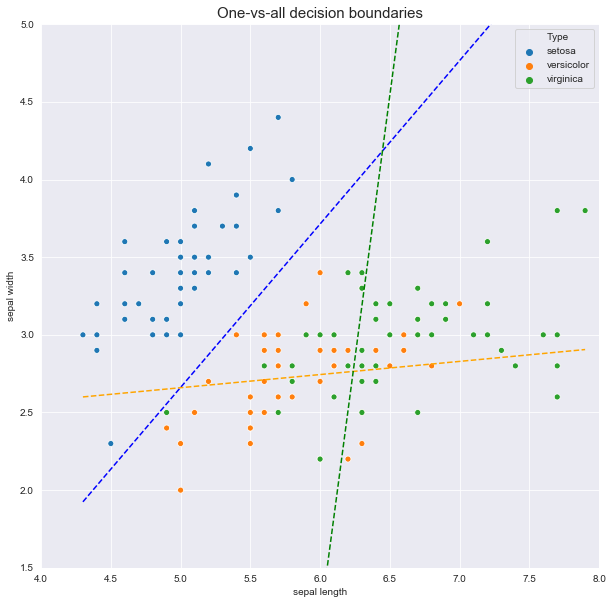

In [15]:
# assign features
sepal_length = X[:,0]
sepal_width = X[:,1]
# create dictionary that will map names to the integer values in y
names = {0:'setosa', 1:'versicolor', 2:'virginica'}
# create list which replaces integer values in y with the corresponding names
y_names = []
for i in y:
    y_names.append(names[i])
# generate dataframe from data for preferred plotting method
data = {'sepal length': sepal_length, 'sepal width': sepal_width, 'y': y,
        'Type': y_names}
df = pd.DataFrame(data)
# plot data
fig = plt.figure(figsize = (10, 10))
sns.set_style('darkgrid')
ax = sns.scatterplot(data = df, x = 'sepal length', y = 'sepal width',
                     hue = 'Type')

# generate points for plotting decision boundaries
x = np.linspace(min(sepal_length), max(sepal_length), 100)
# get coefficients and intercept for first boundary
a1, b1 = log_reg.coef_[0][0], log_reg.coef_[0][1]
c1 = log_reg.intercept_[0]
dec1 = -(a1/b1)*x - (c1/b1)
# get coefficients and intercept for second boundary
a2, b2 = log_reg.coef_[1][0], log_reg.coef_[1][1]
c2 = log_reg.intercept_[1]
dec2 = -(a2/b2)*x - (c2/b2)
# get coefficients and intercept for third boundary
a3, b3 = log_reg.coef_[2][0], log_reg.coef_[2][1]
c3 = log_reg.intercept_[2]
dec3 = -(a3/b3)*x - (c3/b3)
# plot boundaries
ax.plot(x, dec1, color = 'b', linestyle = 'dashed')
ax.plot(x, dec2, color = 'orange', linestyle = 'dashed')
ax.plot(x, dec3, color = 'g', linestyle = 'dashed')
ax.set_xlim(4, 8)
ax.set_ylim(1.5, 5)
ax.set_title('One-vs-all decision boundaries', fontsize = 15)
plt.show()

Now we will visualise the multiclass decision boundaries. The method we employ involves creating a grid of points and using the predict method to predict the classification (0, 1 or 2) of each point. A different colour is assigned to each of the three possible outcomes, generating the coloured areas on the plot

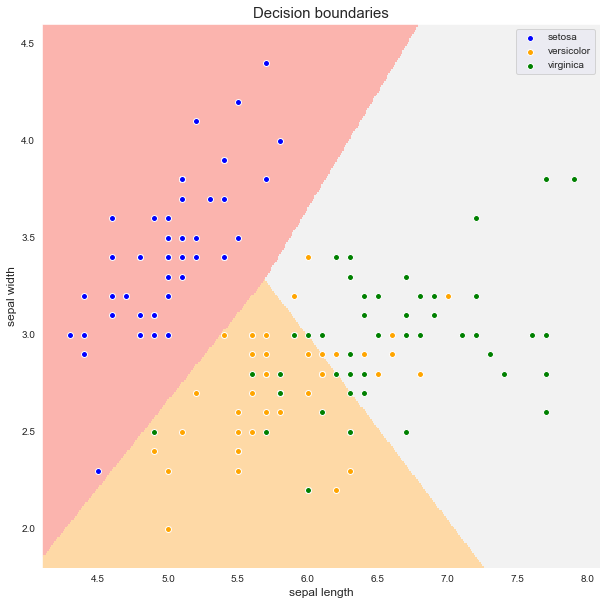

In [18]:
x_min = min(sepal_length) - 0.2
x_max = max(sepal_length) + 0.2
y_min = min(sepal_width) - 0.2
y_max = max(sepal_width) + 0.2
# step size in the grid
dr = 0.01
# generate meshgrid with x values from x_min to x_man and y values from y_min to y_max
X1, Y1 = np.meshgrid(np.arange(x_min, x_max, dr), np.arange(y_min, y_max, dr))
# transform meshgrid to a format compatible with sklearn
stack = np.column_stack((X1.ravel(), Y1.ravel()))
# make predictions on stack
predictions = log_reg.predict(stack)
# reshape predictions into grid for plotting
predictions = predictions.reshape(X1.shape)
# generate plot
fig2 = plt.figure(figsize = (10, 10))
ax2 = fig2.add_subplot(111)
ax2.pcolormesh(X1, Y1, predictions, cmap= 'Pastel1')
# add data points to plot
setosa = df[df['Type'] == 'setosa']
versicolor = df[df['Type'] == 'versicolor']
virginica = df[df['Type'] == 'virginica']   
ax2.scatter(setosa['sepal length'], setosa['sepal width'], color = 'blue',
            edgecolor = 'white', label = 'setosa')
ax2.scatter(versicolor['sepal length'], versicolor['sepal width'], color = 'orange',
            edgecolor = 'white', label = 'versicolor')
ax2.scatter(virginica['sepal length'], virginica['sepal width'], color = 'green',
            edgecolor = 'white', label = 'virginica')
ax2.set_xlabel('sepal length', fontsize = 12)
ax2.set_ylabel('sepal width', fontsize = 12)
ax2.set_title('Decision boundaries', fontsize = 15)
plt.legend()
plt.show()

Finally, we will generate Receiver Operator Characteristic (ROC) curves and Area Under Curve (AUC) scores for the different classes to help evaluate model performance. The ROC curve is a plot of the true positive rate vs false positive rate as the hypothesis function threshold is varied. The AUC score is, as the name suggests, just the area under the ROC curve, and can be used as a general measure of predictive accuracy. 

In order to plot the ROC curves we have to utilise one-hot encoding. Binary columns are created from the input array of numerical categorical data, with the new binary columns indicating the values of the original array.

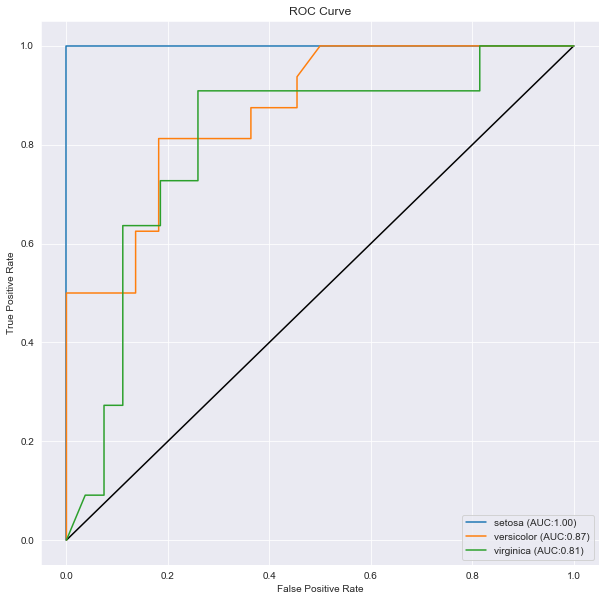

In [23]:
# there are 3 possible values in y_test
# in order to plot multiple ROC curves we have to 'one hot encode'
# y_onehot consists of 3 columns, one for each possible y value
# if y_test_i = 2 for a sample in y_test, then the third column in y_onehot is assigned 1 and all the others get a 0
y_onehot = pd.get_dummies(y_test)
# compute predicted y probabilities from X_test
y_pred_prob = log_reg.predict_proba(X_test)

# create plot and add straight line
fig3 = plt.figure(figsize = (10, 10))
ax3 = fig3.add_subplot(111)
ax3.plot([0, 1], [0, 1], color = 'k')

# plot curve for each classification
# for each column...
for i in range(y_onehot.shape[1]):
    y_actual = y_onehot.iloc[:, i]
    y_prob = y_pred_prob[:, i]
    fpr, tpr, _ = roc_curve(y_actual, y_prob)
    auc_score = roc_auc_score(y_actual, y_prob)

    ax3.plot(fpr, tpr, label = '{} (AUC:{:.2f})'.format(names[i], auc_score))

ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curve')
plt.legend()
plt.show()

All our indicators demonstrate that the model performs best for the setosa class.